In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

import dimensionality_reduction as dr

In [2]:
#Get the IRIS dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
data = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
 
#prepare the data
x = data.iloc[:,0:4]

#prepare the target
target = data.iloc[:,4]
 
#Applying it to PCA
pca = PCA(2)
mat_reduced = pca.fit_transform(x)

#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2'])
 
#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , pd.DataFrame(target)] , axis = 1)

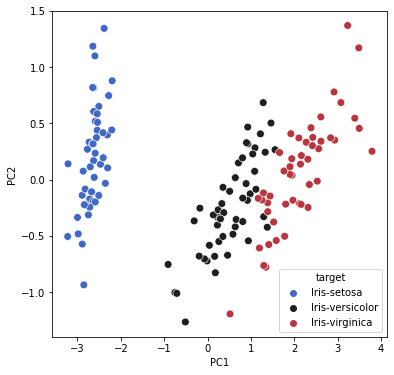

In [3]:
plt.figure(figsize = (6,6))
sb.scatterplot(data = principal_df , x = 'PC1', y = 'PC2' , hue = 'target' , s = 60 , palette= 'icefire');

# This is Not a homework

In [4]:
pca = dr.ImpPCA(n_components=2)
pca.fit(x)
df = pca.transform(x)

principal_df = pd.DataFrame(df , columns = ['PC1','PC2'])
 
#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , pd.DataFrame(target)] , axis = 1)

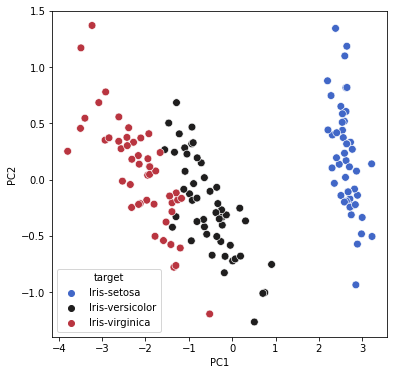

In [5]:
plt.figure(figsize = (6,6))
sb.scatterplot(data = principal_df , x = 'PC1', y = 'PC2' , hue = 'target' , s = 60 , palette= 'icefire');

# This is homework

In [23]:
import numpy as np
import pandas as pd

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

X = mnist.data
y = mnist.target
X.shape

(70000, 784)

### For different number of componentns apply PCA to X
### Check accuracy on test,  time needed for transforming data and fitting the model
### Create a table as shown below (number of components in the table are not mandatory to use)
### You can apply some scalings to the dataset if you find it neccessary

![title](res/table.png)

Scale numbers between 0 and one.

In [61]:
X = X / X.values.max()
X.values.max(), X.values.min()

(1.0, 0.0)

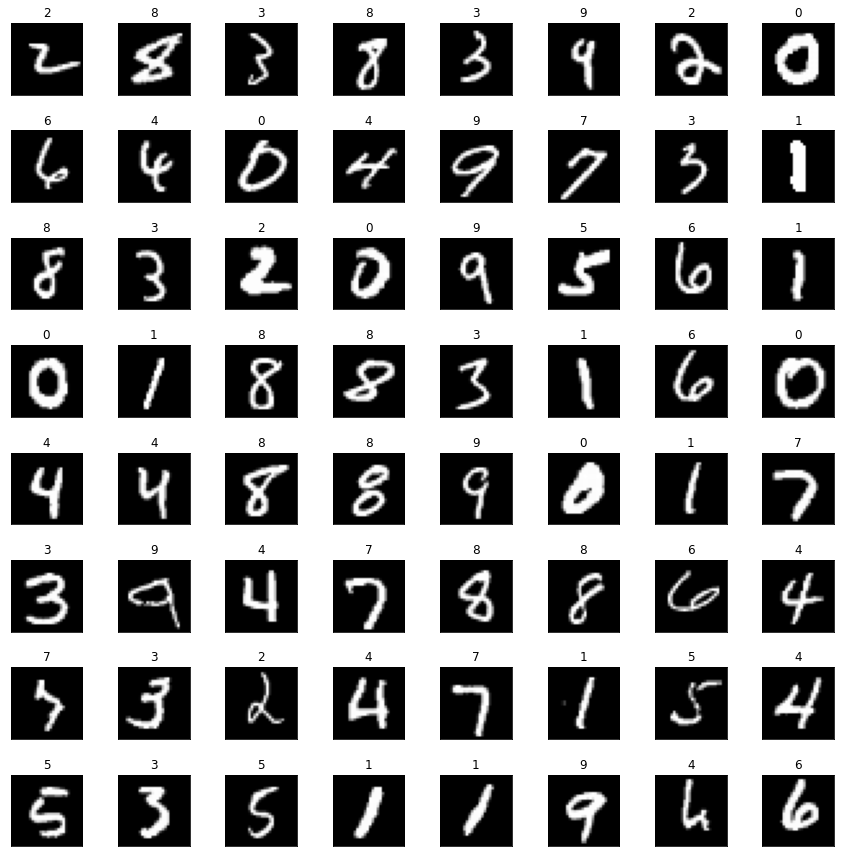

In [60]:
w, h = 8, 8

fig, ax = plt.subplots(w, h, figsize=(12, 12))
fig.tight_layout(pad=0.5)
for i in range(w):
    for j in range(h):
        rand_int = np.random.randint(len(X.values))
        ax[i, j].imshow(X.values[rand_int].reshape(28, 28), cmap="gray")
        
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(y.values[rand_int])
        
plt.show()

In [96]:
import time
import random
import itertools as it

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022, shuffle=True, stratify=y)

In [130]:
def fit_with_n_comp(start, end, step):
    k_folds = KFold(n_splits=5)

    pca_param_grid = {
        "n_components" : np.arange(start, end, step)
    }

    log_reg_param_grid = {
        "C" : np.linspace(0.1, 5, 5) # inverse of regularization
    }

    search_results = {}

    for pca_params in it.product(*pca_param_grid.values()):
        pca = PCA(pca_params[0])
        
        t1 = time.time()

        X_train_trans = pca.fit_transform(X)
        
        tr_time = time.time() - t1

        est = LogisticRegression(max_iter=10000)

        rand_search = RandomizedSearchCV(
            est, log_reg_param_grid, 
            scoring="accuracy", 
            refit=True, verbose=2, random_state=2022, cv=k_folds, n_jobs=-1)

        rand_search.fit(X_train_trans, y)
        search_results[pca_params[0]] = {
            "results" : rand_search.cv_results_,
            "trans_time" : tr_time
        }
    
    return search_results

Let's explore a bit and see what are some possible values of n to choose.

In [131]:
# fit 1
result_dict = {}
result_dict["1"] = fit_with_n_comp(2, 200, 50)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [132]:
results_df = pd.DataFrame()

In [133]:
results_df["n_components"] = []
results_df["cross_validation_test_accuracy"] = []
results_df["mean_training_time"] = []
results_df["transformation_time"] = []

In [162]:
for i, (n, result) in enumerate(result_dict["1"].items()):
    test_score = np.array([result["results"]["split0_test_score"],
              result["results"]["split1_test_score"],
              result["results"]["split2_test_score"],
              result["results"]["split3_test_score"]])
    arg_max_test_score = test_score.mean(axis=0).argmax()
    max_test_score = test_score.mean(axis=0)[arg_max_test_score]
    mean_train_time = result["results"]["mean_fit_time"][arg_max_test_score]
    results_df.loc[i] = [n, max_test_score, mean_train_time, result["trans_time"]]

In [163]:
results_df

,n_components,cross_validation_test_accuracy,mean_training_time,transformation_time
0,2.0,0.442375,2.722592,2.672441
1,52.0,0.906357,8.574486,3.940994
2,102.0,0.915589,16.918476,4.153524
3,152.0,0.918339,36.909078,5.000844


**Conslusion:**
Here we search for n in our domain of interest, weather we want more accuracy or prefer low computational time and dimentionality of our data.